In [17]:
import os
import sys
from collections import Counter

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from torch.utils.data import DataLoader, random_split
from torchinfo import summary
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

torch.backends.cudnn.deterministic = True

In [18]:
print("Platform:", sys.platform)
print("Python version:", sys.version)
print("---")
print("matplotlib version:", matplotlib.__version__)
print("pandas version:", pd.__version__)
print("PIL version:", PIL.__version__)
print("torch version:", torch.__version__)
print("torchvision version:", torchvision.__version__)

Platform: linux
Python version: 3.12.9 | packaged by Anaconda, Inc. | (main, Feb  6 2025, 18:56:27) [GCC 11.2.0]
---
matplotlib version: 3.10.1
pandas version: 2.2.3
PIL version: 11.2.1
torch version: 2.6.0+cu124
torchvision version: 0.21.0+cu124


In [19]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Using {device} device.")

Using cpu device.


## Lecture et transformation des fichiers 

In [20]:
class ConvertToRGB:
    def __call__(self, img):
        if img.mode != "RGB":
            img = img.convert("RGB")
        return img

In [21]:
transform = transforms.Compose(
    [
        ConvertToRGB(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)

In [22]:
import os
from pathlib import Path

In [23]:
# Chemins des données
RAW_DATA_DIR = Path("/home/pionners03/elfriedkinzounpionniers/data/raw/data")
PROCESSED_DATA_DIR = Path("/home/pionners03/elfriedkinzounpionniers/data/processed")


In [24]:
print("Le data set ", RAW_DATA_DIR)

Le data set  /home/pionners03/elfriedkinzounpionniers/data/raw/data


In [25]:
# Ensure that the dataset is correctly initialized without accessing non-existent attributes
data_set = datasets.ImageFolder(root=RAW_DATA_DIR, transform=transform)

## Créer les DataLoaders

In [26]:
batch_size = 32  # ajustable

data_loader = DataLoader(data_set, batch_size=batch_size, shuffle=True)

In [27]:
# Pour vérifier les classes détectées automatiquement
print("Classes détectées :", data_set.classes)

# Pour tester un batch
images, labels = next(iter(data_loader))
print("Taille d’un batch :", images.shape)


Classes détectées : ['Cassava___bacterial_blight', 'Cassava___brown_streak_disease', 'Cassava___green_mottle', 'Cassava___healthy', 'Cassava___mosaic_disease']
Taille d’un batch : torch.Size([32, 3, 224, 224])


## Calcul des statistiques du dataset (mean & std)

In [28]:
def get_mean_std(loader):
    """Calcule la moyenne et l’écart-type des images dans un DataLoader."""
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in tqdm(loader, desc="Computing mean and std", leave=False):
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches += 1
    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean**2) ** 0.5
    return mean, std


In [29]:
from tqdm import tqdm

In [30]:
# Calculer les statistiques sur le train_loader
mean, std = get_mean_std(data_loader)

print(f"Moyenne : {mean}")
print(f"Écart-type : {std}")

Moyenne : tensor([0.4303, 0.4967, 0.3134])
Écart-type : tensor([0.2206, 0.2236, 0.2117])


In [32]:
transform_norm = transforms.Compose([
    ConvertToRGB(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])


In [33]:
norm_dataset = datasets.ImageFolder(root=RAW_DATA_DIR, transform=transform_norm)
norm_loader = DataLoader(norm_dataset, batch_size=batch_size)

In [40]:
norm_mean, norm_std = get_mean_std(norm_loader)

print(f"Mean: {norm_mean}")
print(f"Standard deviation: {norm_std}")

Mean: tensor([-0.0001, -0.0001, -0.0001])
Standard deviation: tensor([1.0000, 1.0000, 1.0000])


In [34]:
import os
import shutil
from pathlib import Path
import torch
from torchvision import datasets, transforms
from torch.utils.data import random_split
from collections import Counter
import pandas as pd
from tqdm import tqdm

In [46]:
# Si le dossier existe déjà, on le supprime pour repartir propre
if os.path.exists(PROCESSED_DATA_DIR):
    shutil.rmtree(PROCESSED_DATA_DIR)
os.makedirs(PROCESSED_DATA_DIR)


In [47]:
# ✅ Split
dataset_len = len(norm_dataset)
train_len = int(0.7 * dataset_len)
val_len = int(0.15 * dataset_len)
test_len = dataset_len - train_len - val_len

g = torch.Generator().manual_seed(42)
train_dataset, val_dataset, test_dataset = random_split(norm_dataset, [train_len, val_len, test_len], generator=g)

# ✅ Fonction pour copier les images originales dans les dossiers appropriés
def copy_images_from_split(subset, subset_name):
    for idx in range(len(subset)):
        original_index = subset.indices[idx]
        image_path, label = norm_dataset.samples[original_index]
        class_name = norm_dataset.classes[label]
        destination = Path(PROCESSED_DATA_DIR) / subset_name / class_name
        destination.mkdir(parents=True, exist_ok=True)
        shutil.copy(image_path, destination / Path(image_path).name)

# ✅ Copier les fichiers dans les bons dossiers
copy_images_from_split(train_dataset, 'train')
copy_images_from_split(val_dataset, 'val')
copy_images_from_split(test_dataset, 'test')

print(f"[✅] Train: {len(train_dataset)} images")
print(f"[✅] Validation: {len(val_dataset)} images")
print(f"[✅] Test: {len(test_dataset)} images")

[✅] Train: 14977 images
[✅] Validation: 3209 images
[✅] Test: 3211 images


In [35]:
from collections import Counter
import pandas as pd
from tqdm import tqdm

def class_counts(dataset):
    """Compte les occurrences de chaque classe dans un dataset ImageFolder."""
    c = Counter(x[1] for x in tqdm(dataset))
    class_to_index = dataset.class_to_idx
    return pd.Series({cat: c[idx] for cat, idx in class_to_index.items()})


In [36]:
# Recharger les datasets à partir des nouveaux dossiers processing/
train_dataset = datasets.ImageFolder(root='/home/pionners03/elfriedkinzounpionniers/data/processed/train', transform=transform_norm)
val_dataset = datasets.ImageFolder(root='/home/pionners03/elfriedkinzounpionniers/data/processed/val', transform=transform_norm)
test_dataset = datasets.ImageFolder(root='/home/pionners03/elfriedkinzounpionniers/data/processed/test', transform=transform_norm)

# Créer les DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


100%|██████████| 14977/14977 [01:04<00:00, 231.01it/s]


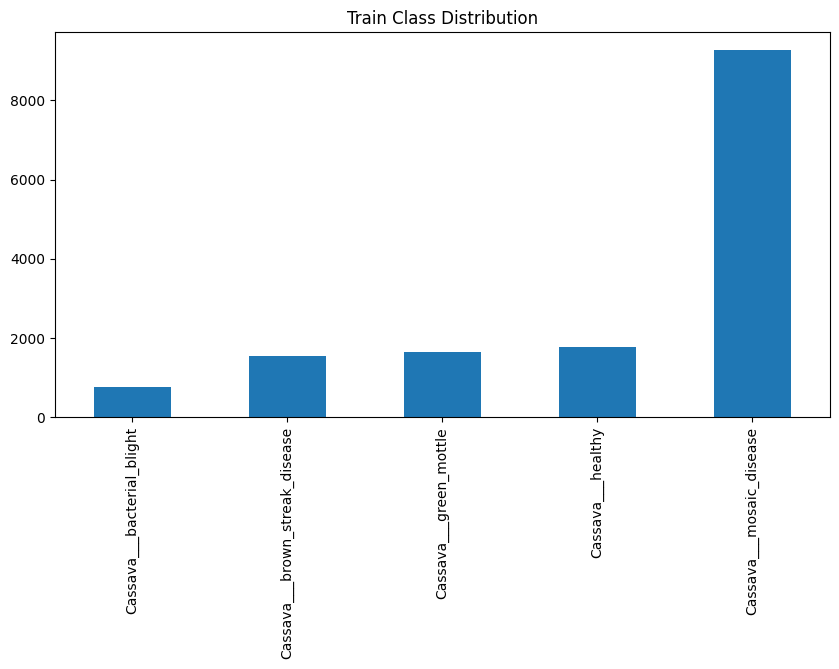

100%|██████████| 3209/3209 [00:13<00:00, 244.90it/s]


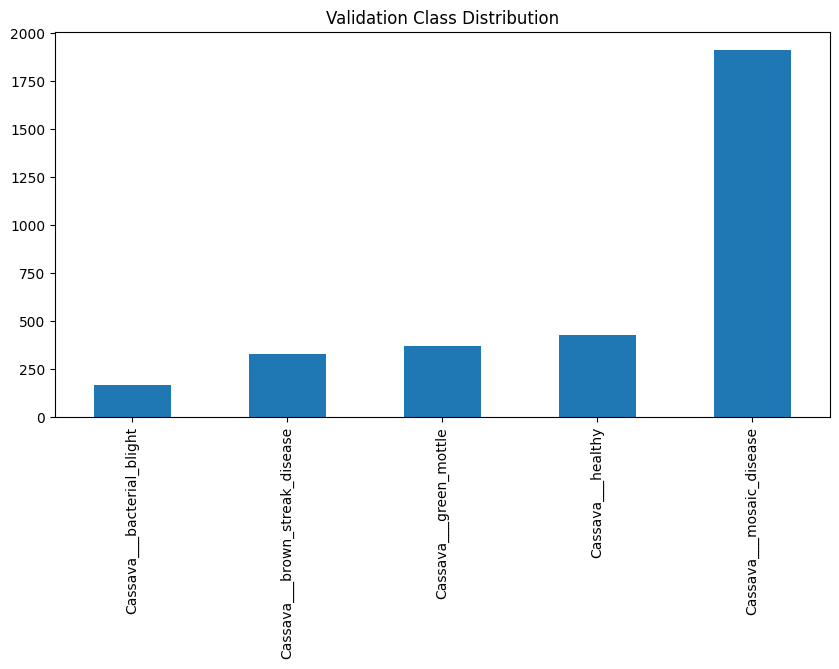

100%|██████████| 3211/3211 [00:15<00:00, 210.19it/s]


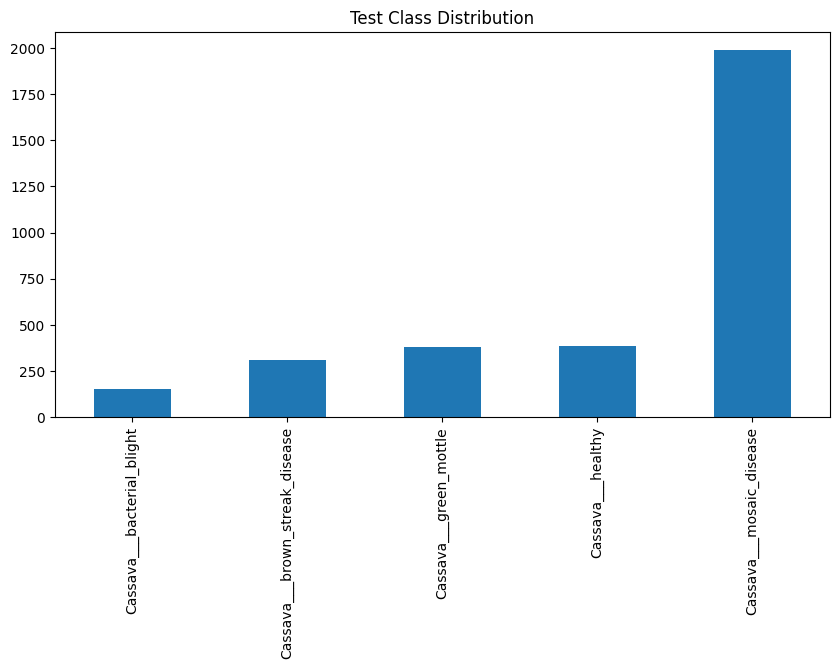

Train classes: ['Cassava___bacterial_blight', 'Cassava___brown_streak_disease', 'Cassava___green_mottle', 'Cassava___healthy', 'Cassava___mosaic_disease']
Validation classes: ['Cassava___bacterial_blight', 'Cassava___brown_streak_disease', 'Cassava___green_mottle', 'Cassava___healthy', 'Cassava___mosaic_disease']
Test classes: ['Cassava___bacterial_blight', 'Cassava___brown_streak_disease', 'Cassava___green_mottle', 'Cassava___healthy', 'Cassava___mosaic_disease']
Train size: 14977
Validation size: 3209
Test size: 3211


In [37]:
train_class_distributions = class_counts(train_dataset)

train_class_distributions.plot(kind="bar", figsize=(10, 5), title="Train Class Distribution")
plt.show()
val_class_distributions = class_counts(val_dataset)
val_class_distributions.plot(kind="bar", figsize=(10, 5), title="Validation Class Distribution")
plt.show()
test_class_distributions = class_counts(test_dataset)
test_class_distributions.plot(kind="bar", figsize=(10, 5), title="Test Class Distribution")
plt.show()
# Vérification des classes
print("Train classes:", train_dataset.classes)
print("Validation classes:", val_dataset.classes)
print("Test classes:", test_dataset.classes)
# Vérification des tailles
print("Train size:", len(train_dataset))
print("Validation size:", len(val_dataset))
print("Test size:", len(test_dataset))

In [38]:
single_batch = next(iter(train_loader))[0]

In [39]:
print(f"Shape of one batch: {single_batch.shape}")

Shape of one batch: torch.Size([32, 3, 224, 224])


In [40]:
import torch.nn as nn
import torch

model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),

    nn.Conv2d(16, 32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),

    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),

    nn.Flatten(),
    nn.Dropout(),
    nn.Linear(64 * 28 * 28, 500),  # <--- Correct ici
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(500, 8)  # <-- nombre de classes
)


In [41]:
from torchsummary import summary
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
              ReLU-2         [-1, 16, 224, 224]               0
         MaxPool2d-3         [-1, 16, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]           4,640
              ReLU-5         [-1, 32, 112, 112]               0
         MaxPool2d-6           [-1, 32, 56, 56]               0
            Conv2d-7           [-1, 64, 56, 56]          18,496
              ReLU-8           [-1, 64, 56, 56]               0
         MaxPool2d-9           [-1, 64, 28, 28]               0
          Flatten-10                [-1, 50176]               0
          Dropout-11                [-1, 50176]               0
           Linear-12                  [-1, 500]      25,088,500
             ReLU-13                  [-1, 500]               0
          Dropout-14                  [

In [42]:
from training import predict, train

In [43]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.to(device)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Dropout(p=0.5, inplace=False)
  (11): Linear(in_features=50176, out_features=500, bias=True)
  (12): ReLU()
  (13): Dropout(p=0.5, inplace=False)
  (14): Linear(in_features=500, out_features=8, bias=True)
)

Training Epoch 1/10: 100%|██████████| 469/469 [03:20<00:00,  2.34it/s]


Epoch 1/10 - Loss: 1.0686 - Accuracy: 62.57%
Validation - Loss: 0.9442 - Accuracy: 64.10%



Training Epoch 2/10: 100%|██████████| 469/469 [03:27<00:00,  2.26it/s]


Epoch 2/10 - Loss: 0.8997 - Accuracy: 66.17%
Validation - Loss: 0.9068 - Accuracy: 64.29%



Training Epoch 3/10: 100%|██████████| 469/469 [03:39<00:00,  2.14it/s]


Epoch 3/10 - Loss: 0.8201 - Accuracy: 68.84%
Validation - Loss: 0.8181 - Accuracy: 68.68%



Training Epoch 4/10: 100%|██████████| 469/469 [03:25<00:00,  2.28it/s]


Epoch 4/10 - Loss: 0.7408 - Accuracy: 72.14%
Validation - Loss: 0.8401 - Accuracy: 67.68%



Training Epoch 5/10: 100%|██████████| 469/469 [03:30<00:00,  2.23it/s]


Epoch 5/10 - Loss: 0.6314 - Accuracy: 76.48%
Validation - Loss: 0.8170 - Accuracy: 68.99%



Training Epoch 6/10: 100%|██████████| 469/469 [03:06<00:00,  2.52it/s]


Epoch 6/10 - Loss: 0.5027 - Accuracy: 81.29%
Validation - Loss: 0.8965 - Accuracy: 66.91%



Training Epoch 7/10: 100%|██████████| 469/469 [03:06<00:00,  2.52it/s]


Epoch 7/10 - Loss: 0.4059 - Accuracy: 84.99%
Validation - Loss: 1.0053 - Accuracy: 67.50%



Training Epoch 8/10: 100%|██████████| 469/469 [03:25<00:00,  2.29it/s]


Epoch 8/10 - Loss: 0.2967 - Accuracy: 89.28%
Validation - Loss: 1.2184 - Accuracy: 68.40%



Training Epoch 9/10: 100%|██████████| 469/469 [03:08<00:00,  2.49it/s]


Epoch 9/10 - Loss: 0.2320 - Accuracy: 91.53%
Validation - Loss: 1.2020 - Accuracy: 69.18%



Training Epoch 10/10: 100%|██████████| 469/469 [03:25<00:00,  2.28it/s]


Epoch 10/10 - Loss: 0.1957 - Accuracy: 93.19%
Validation - Loss: 1.1924 - Accuracy: 68.28%



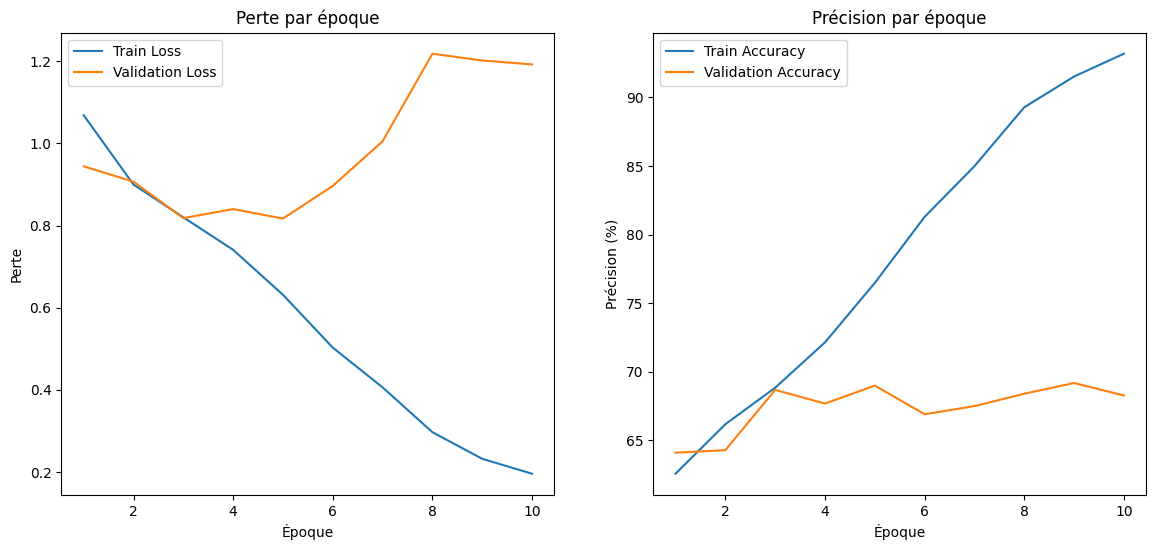

In [44]:
import matplotlib.pyplot as plt

# Entraîner le modèle et récupérer les métriques
model, metrics = train(model, train_loader, val_loader, loss_fn, optimizer, device, epochs=10)

# Extraction des métriques
train_losses = metrics["train_losses"]
val_losses = metrics["val_losses"]
train_accs = metrics["train_accs"]
val_accs = metrics["val_accs"]

epochs_range = range(1, len(train_losses) + 1)

# Tracer les courbes de perte
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, val_losses, label="Validation Loss")
plt.title("Perte par époque")
plt.xlabel("Époque")
plt.ylabel("Perte")
plt.legend()

# Tracer les courbes de précision
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accs, label="Train Accuracy")
plt.plot(epochs_range, val_accs, label="Validation Accuracy")
plt.title("Précision par époque")
plt.xlabel("Époque")
plt.ylabel("Précision (%)")
plt.legend()

plt.show()


In [46]:
# prédiction sur le jeu de test
predictions = predict(model, test_loader, device)   

Matrice de confusion :
[[  33   26    6   61   29]
 [  17  105   20   83   82]
 [   7   15  111   91  154]
 [  21   34   51  193   86]
 [   2   42   76   65 1801]]


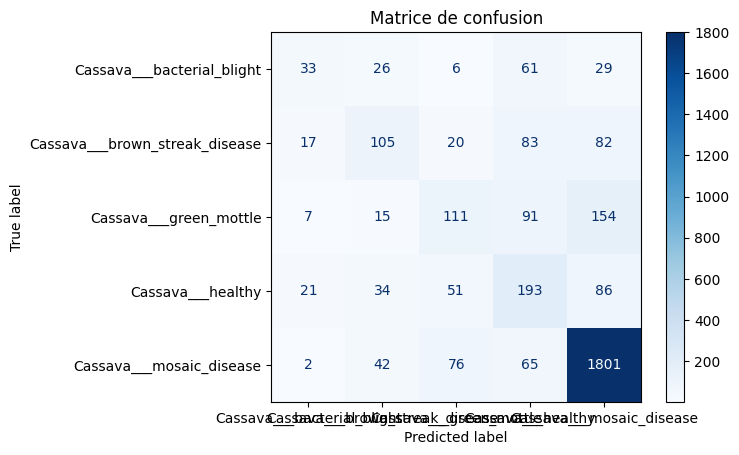

In [47]:
# Calculer la matrice de confusion
y_true = test_dataset.targets

y_pred = predictions
conf_matrix = confusion_matrix(y_true, y_pred)
# Afficher la matrice de confusion

print("Matrice de confusion :") 
print(conf_matrix)
labels = test_dataset.classes
cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels)
cm_display.plot(cmap=plt.cm.Blues)
plt.title("Matrice de confusion")
plt.show()

## Nouvelle essaie sur le dataset 

In [54]:
from collections import Counter
import torch

# 🔍 Récupérer les labels depuis le Subset
train_labels = [train_dataset.samples[i][1] for i in train_dataset.indices] if hasattr(train_dataset, 'indices') else [sample[1] for sample in train_dataset.samples]

# 📊 Compter les occurrences
counts = Counter(train_labels)
num_classes = len(train_dataset.classes)

# ⚖️ Calcul des poids inverses
class_weights = [0.0] * num_classes
for cls_idx, cnt in counts.items():
    class_weights[cls_idx] = 1.0 / cnt

# 📈 Conversion en Tensor
class_weights = torch.FloatTensor(class_weights).to(device)

# ✅ Fonction de perte pondérée
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)


In [61]:
# Sauvegarder les poids du modèle
torch.save(model.state_dict(), "model_weights.pth")

# Sauvegarder l'intégralité du modèle
torch.save(model, "model_complete.pth")

print("Modèle sauvegardé avec succès.")

Modèle sauvegardé avec succès.


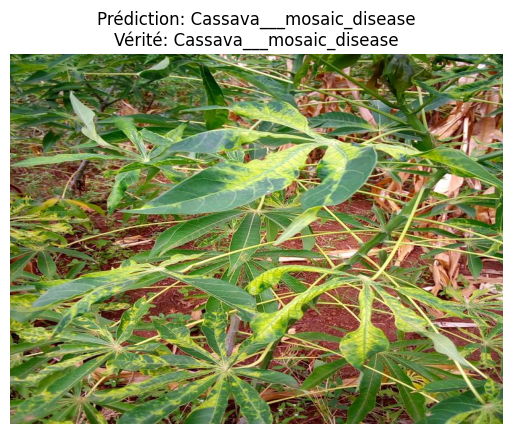

In [67]:
import random
from PIL import Image

# Sélectionner une image aléatoire du test set
random_idx = random.randint(0, len(test_dataset) - 1)
image_path, true_label = test_dataset.samples[random_idx]
image = Image.open(image_path)

# Prétraiter l'image pour correspondre au modèle
input_tensor = transform_norm(image).unsqueeze(0).to(device)

# Faire une prédiction
model.eval()
with torch.no_grad():
    output = model(input_tensor)
    predicted_label = torch.argmax(output, dim=1).item()

# Afficher l'image avec la classe prédite et la classe réelle
plt.imshow(image)
plt.title(f"Prédiction: {test_dataset.classes[predicted_label]}\nVérité: {test_dataset.classes[true_label]}")
plt.axis("off")
plt.show()

In [ ]:
# Charger les poids du modèle sauvegardé
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(16, 32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Flatten(),
    nn.Dropout(),
    nn.Linear(64 * 28 * 28, 500),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(500, 8)
)

# Charger les poids sauvegardés
model.load_state_dict(torch.load("model_weights.pth"))
model.to(device)
model.eval()

# Exemple de prédiction
with torch.no_grad():
    output = model(input_tensor)
    predicted_label = torch.argmax(output, dim=1).item()
    print(f"Classe prédite : {predicted_label}")

In [55]:
from torch.utils.data import DataLoader, WeightedRandomSampler

# Poids des exemples selon leur classe
sample_weights = [class_weights[label].item() for label in train_labels]

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True,
    generator=torch.Generator().manual_seed(42)
)


In [56]:
batch_size = 32  # ou celui que tu utilises

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


In [58]:
from torchvision import transforms

# Exemple de pipeline de data augmentation
augment_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)  # tes propres valeurs
])

# L’appliquer uniquement sur le dataset d’entraînement
train_dataset.transform = augment_transform


In [59]:
import matplotlib.pyplot as plt

def plot_learning_curves(history):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(14, 5))

    # Courbe des pertes
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label='Train Loss')
    plt.plot(epochs, history["val_loss"], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Courbe de perte')
    plt.legend()

    # Courbe des précisions
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_acc"], label='Train Accuracy')
    plt.plot(epochs, history["val_acc"], label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Courbe de précision')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [60]:
from torch import optim

optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Entraînement
model1, metrics = train(
    model,
    train_loader,
    val_loader,
    loss_fn,
    optimizer,
    device,
    epochs=10
)


Training Epoch 1/10:   0%|          | 0/469 [00:00<?, ?it/s]


RuntimeError: weight tensor should be defined either for all 8 classes or no classes but got weight tensor of shape: [5]